In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import glob
import time
import imageio
from tqdm import tqdm
import xml.etree.ElementTree as ET 

import PIL

import tensorflow as tf

# libraries for SpectralNorm
from tensorflow.keras import backend as K
from keras.engine import *
from keras.legacy import interfaces
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from keras.utils.generic_utils import func_dump
from keras.utils.generic_utils import func_load
from keras.utils.generic_utils import deserialize_keras_object
from keras.utils.generic_utils import has_arg
from keras.utils import conv_utils
from tensorflow.keras.layers import Dense, Conv2DTranspose, Conv2D

Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()

In [3]:
ROOT = '../input/generative-dog-images/'
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs/')
BREEDS = os.listdir(ROOT + 'annotation/Annotation/')

In [4]:
def take_only_dogs():
    images_ds = np.zeros((22125, 64, 64, 3))
    idx = 0
    for breed in tqdm(BREEDS):
        for dog in os.listdir(ROOT + 'annotation/Annotation/' + breed):
            try:
                img = PIL.Image.open(ROOT + 'all-dogs/all-dogs/' + dog + '.jpg')
            except:
                continue
            tree = ET.parse(ROOT + 'annotation/Annotation/' + breed + '/' + dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin + w, ymin + w))
                img2 = img2.resize((64,64), PIL.Image.ANTIALIAS)
                images_ds[idx,:,:,:] = img2
                idx += 1
    return images_ds

In [5]:
images_ds = take_only_dogs()

100%|██████████| 120/120 [03:05<00:00,  1.55s/it]


In [6]:
images_ds = (images_ds / 127.5) - 1

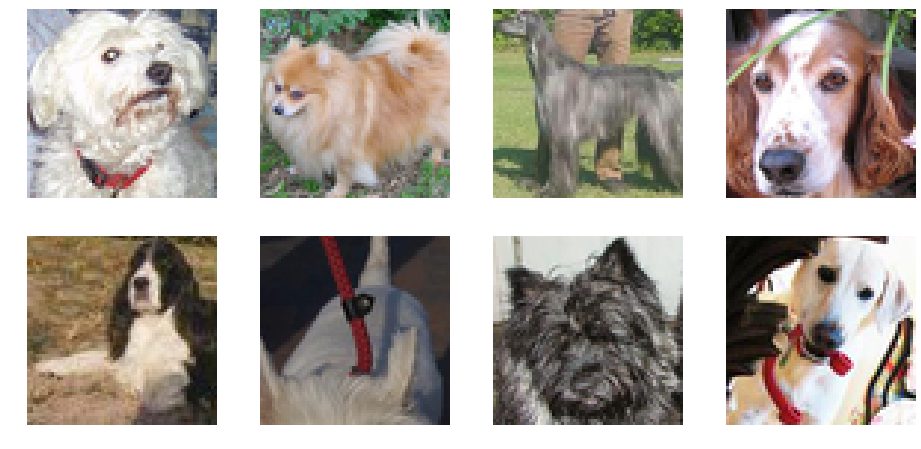

In [7]:
fig = plt.figure(figsize=(16,16))

sample = np.random.randint(images_ds.shape[0], size=8)
for i, image in enumerate(images_ds[sample]):
    plt.subplot(4, 4, i+1)
    plt.imshow((image / 2) + 0.5)
    plt.axis('off')

plt.show()

In [8]:
dog_features_tf = tf.cast(images_ds, 'float32')

In [9]:
SAMPLE_SIZE = 22125
BATCH_SIZE = 128

In [10]:
dog_features_data = tf.data.Dataset.from_tensor_slices(dog_features_tf).shuffle(SAMPLE_SIZE).batch(BATCH_SIZE)

In [11]:
print(dog_features_data)

<DatasetV1Adapter shapes: (?, 64, 64, 3), types: tf.float32>


In [12]:
class DenseSN(Dense):
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True
        
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                 W_bar = K.reshape(W_bar, W_shape)  
        output = K.dot(inputs, W_bar)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output 
    
class ConvSN2D(Conv2D):

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv2d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

class ConvSN2DTranspose(Conv2DTranspose):

    def build(self, input_shape):
        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (self.filters, input_dim)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True  
    
    def call(self, inputs):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_length(height,
                                              stride_h, kernel_h,
                                              self.padding,
                                              out_pad_h)
        out_width = conv_utils.deconv_length(width,
                                             stride_w, kernel_w,
                                             self.padding,
                                             out_pad_w)
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)
            
        #Spectral Normalization    
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
        self.kernel = W_bar
        
        outputs = K.conv2d_transpose(
            inputs,
            self.kernel,
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

In [13]:
NOISE_DIM = 128

In [14]:
def gen_noise(batch_size):
	x_input = np.random.randn(NOISE_DIM * batch_size)
	x_input = x_input.reshape((batch_size, NOISE_DIM))
	return x_input

In [15]:
def make_generator_model():
    init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    model = tf.keras.models.Sequential(name='generator')
    model.add(tf.keras.layers.Dense(2048, input_shape=(NOISE_DIM,), kernel_initializer=init))
    model.add(tf.keras.layers.Reshape((4, 4, 128)))
    
    model.add(tf.keras.layers.Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', kernel_initializer=init))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    
    model.add(tf.keras.layers.Dense(3, activation='tanh', kernel_initializer=init))

    return model   

In [16]:
generator = make_generator_model()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              264192    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         1638912   
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 4, 4, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         32

In [17]:
def make_discriminator_model():
    init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    model = tf.keras.models.Sequential(name='discriminator')
    
    model.add(ConvSN2D(64, (5, 5), strides=(1,1), padding='same', use_bias=False, input_shape=(64, 64, 3), kernel_initializer=init))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(ConvSN2D(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(ConvSN2D(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(ConvSN2D(256, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(DenseSN(1, activation='sigmoid'))

    return model

In [18]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_s_n2d (ConvSN2D)        (None, 64, 64, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv_s_n2d_1 (ConvSN2D)      (None, 32, 32, 64)        102464    
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv_s_n2d_2 (ConvSN2D)      (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)     

In [19]:
# Label smoothing -- technique from GAN hacks, instead of assigning 1/0 as class labels, we assign a random integer in range [0.7, 1.0] for positive class
# and [0.0, 0.3] for negative class

def smooth_positive_labels(y):
    return tf.cast(y, tf.float32) - 0.3 + (np.random.random(y.shape) * 0.5)

def smooth_negative_labels(y):
    return y + np.random.random(y.shape) * 0.3

In [20]:
# randomly flip some labels
def noisy_labels(y, p_flip):
    # determine the number of labels to flip
    n_select = int(p_flip * int(y.shape[0]))
    # choose labels to flip
    flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)
    
    op_list = []
    # invert the labels in place
    #y_np[flip_ix] = 1 - y_np[flip_ix]
    for i in range(int(y.shape[0])):
        if i in flip_ix:
            op_list.append(tf.subtract(1, y[i]))
        else:
            op_list.append(y[i])
    
    outputs = tf.stack(op_list)
    return outputs

In [21]:
INITIAL_LR_GEN=0.0002
INITIAL_LR_DIS=0.0002

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=INITIAL_LR_GEN, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=INITIAL_LR_DIS, beta_1=0.5)

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [23]:
def discriminator_loss(real_output, fake_output):
    real_output_noise = noisy_labels(tf.ones_like(real_output, dtype='int32'), 0.05)
    fake_output_noise = noisy_labels(tf.zeros_like(fake_output, dtype='int32'), 0.05)
    
    real_output_smooth = smooth_positive_labels(real_output_noise)
    fake_output_smooth = smooth_negative_labels(fake_output_noise)
    
    real_loss = cross_entropy(tf.ones_like(real_output_smooth), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output_smooth), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss    

In [24]:
def generator_loss(real_output, fake_output):
    fake_output_smooth = smooth_negative_labels(tf.ones_like(fake_output))
    
    return cross_entropy(tf.ones_like(fake_output_smooth), fake_output)

In [25]:
checkpoint_dir = '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [26]:
EPOCHS = 280
N_EXAMPLES = 64
SEED = tf.random.normal([N_EXAMPLES, NOISE_DIM])

In [27]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(real_output, fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [28]:
def generate_and_save_images(model, epoch, test_input, rows, cols):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(14,14))
    
    for i in range(predictions.shape[0]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow((predictions[i, :, :, :]  / 2) + 0.5)
        plt.axis('off')
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
#     plt.show()
    
    return predictions

In [29]:
def generate_test_image(model, noise_dim=NOISE_DIM):
    test_input = tf.random.normal([1, noise_dim])
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(5,5))
    plt.imshow((predictions[0, :, :, :]  / 2) + 0.5)
    plt.axis('off') 
    plt.show()

In [30]:
def train(dataset, epochs):
    
    all_gl = np.array([]); all_dl = np.array([])
    
    images_progress = np.zeros((epochs, 64, 64, 64, 3))
    decay_step = 50
    lr_decay_steps = 1000
    
    initial_time = time.time()

    for epoch in tqdm(range(epochs)):
        
        G_loss = []; D_loss = []
        
        start = time.time()
        new_lr_gen = INITIAL_LR_GEN
        new_lr_dis = INITIAL_LR_DIS
        global_step = 0
        
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            global_step = global_step + 1
            G_loss.append(g_loss); D_loss.append(d_loss)
            all_gl = np.append(all_gl,np.array([G_loss]))
            all_dl = np.append(all_dl,np.array([D_loss]))
              
#         images_progress[epoch] = generate_and_save_images(generator, epoch + 1, SEED, rows=8, cols=8)
        images_progress[epoch] = generator.predict(SEED)
        
        if (epoch + 1) % decay_step == 0:
            new_lr_gen = tf.train.cosine_decay(new_lr_gen, min(global_step, lr_decay_steps), lr_decay_steps)
            new_lr_dis = tf.train.cosine_decay(new_lr_dis, min(global_step, lr_decay_steps), lr_decay_steps)
            generator_optimizer = tf.keras.optimizers.Adam(learning_rate=new_lr_gen, beta_1=0.5)
            discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=new_lr_dis, beta_1=0.5)         

        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            generator.save('generator.h5')
            np.save('images_progress.npy', images_progress[:epoch + 1])
            
        print('Epoch: {} computed for {} sec'.format(epoch + 1, time.time() - start),
              'Gen_loss mean: ', np.mean(G_loss),' std: ', np.std(G_loss),
              'Disc_loss mean: ', np.mean(D_loss),' std: ', np.std(D_loss), sep='\n')
        
        if time.time() - initial_time > 28000:
            images_progress = images_progress[:epoch - 1, :, :, :, :]
            break

    generate_and_save_images(generator, epochs, SEED, rows=8, cols=8)
    checkpoint.save(file_prefix = checkpoint_prefix)
    np.save('images_progress.npy', images_progress)
    generator.save('generator.h5')
    print('Final epoch.')
    return images_progress

In [31]:
os.mkdir('training_checkpoints')
os.mkdir('images')

  0%|          | 1/280 [01:57<9:05:17, 117.27s/it]

Epoch: 1 computed for 117.01385974884033 sec
Gen_loss mean: 
4.07754
 std: 
2.540153
Disc_loss mean: 
0.24532479
 std: 
0.41698876


  1%|          | 2/280 [03:49<8:55:49, 115.65s/it]

Epoch: 2 computed for 111.61306619644165 sec
Gen_loss mean: 
3.4786658
 std: 
1.9033024
Disc_loss mean: 
0.30882362
 std: 
0.7084641


  1%|          | 3/280 [05:40<8:48:12, 114.41s/it]

Epoch: 3 computed for 111.27392077445984 sec
Gen_loss mean: 
3.3286345
 std: 
2.0167208
Disc_loss mean: 
0.39265725
 std: 
0.52341914


  1%|▏         | 4/280 [07:33<8:44:14, 113.97s/it]

Epoch: 4 computed for 112.65627121925354 sec
Gen_loss mean: 
3.4039297
 std: 
1.944478
Disc_loss mean: 
0.34065917
 std: 
0.4775018


  2%|▏         | 5/280 [09:26<8:40:13, 113.50s/it]

Epoch: 5 computed for 112.19382691383362 sec
Gen_loss mean: 
3.3461936
 std: 
2.1604128
Disc_loss mean: 
0.42142296
 std: 
0.5537618


  2%|▏         | 6/280 [11:18<8:36:53, 113.19s/it]

Epoch: 6 computed for 112.21161961555481 sec
Gen_loss mean: 
3.1687922
 std: 
1.8100121
Disc_loss mean: 
0.44325387
 std: 
0.3853332


  2%|▎         | 7/280 [13:11<8:35:01, 113.19s/it]

Epoch: 7 computed for 112.9567596912384 sec
Gen_loss mean: 
3.0874996
 std: 
1.4907838
Disc_loss mean: 
0.3515669
 std: 
0.28966594


  3%|▎         | 8/280 [15:03<8:31:27, 112.82s/it]

Epoch: 8 computed for 111.69873452186584 sec
Gen_loss mean: 
3.0645077
 std: 
1.6063274
Disc_loss mean: 
0.4067869
 std: 
0.34677133


  3%|▎         | 9/280 [16:56<8:30:01, 112.92s/it]

Epoch: 9 computed for 112.91450476646423 sec
Gen_loss mean: 
2.615832
 std: 
1.29616
Disc_loss mean: 
0.5410218
 std: 
0.28250483


  4%|▎         | 10/280 [18:49<8:28:17, 112.95s/it]

Epoch: 10 computed for 112.8012592792511 sec
Gen_loss mean: 
2.4162886
 std: 
1.0468987
Disc_loss mean: 
0.48660865
 std: 
0.2847527


  4%|▍         | 11/280 [20:42<8:25:32, 112.76s/it]

Epoch: 11 computed for 112.06046891212463 sec
Gen_loss mean: 
2.4239979
 std: 
1.2422308
Disc_loss mean: 
0.5862982
 std: 
0.33705288


  4%|▍         | 12/280 [22:35<8:24:12, 112.88s/it]

Epoch: 12 computed for 112.91663122177124 sec
Gen_loss mean: 
2.2985706
 std: 
1.0868454
Disc_loss mean: 
0.55120736
 std: 
0.2860087


  5%|▍         | 13/280 [24:27<8:21:56, 112.80s/it]

Epoch: 13 computed for 112.34413504600525 sec
Gen_loss mean: 
2.200422
 std: 
1.1822901
Disc_loss mean: 
0.6913082
 std: 
0.38722855


  5%|▌         | 14/280 [26:20<8:19:49, 112.74s/it]

Epoch: 14 computed for 112.34713101387024 sec
Gen_loss mean: 
2.0949714
 std: 
0.89560795
Disc_loss mean: 
0.6028944
 std: 
0.25480723


  5%|▌         | 15/280 [28:12<8:17:36, 112.66s/it]

Epoch: 15 computed for 112.2510039806366 sec
Gen_loss mean: 
2.1992702
 std: 
1.1420475
Disc_loss mean: 
0.65884936
 std: 
0.29914683


  6%|▌         | 16/280 [30:05<8:15:04, 112.52s/it]

Epoch: 16 computed for 111.92674088478088 sec
Gen_loss mean: 
2.0288448
 std: 
0.851373
Disc_loss mean: 
0.6359633
 std: 
0.34209964


  6%|▌         | 17/280 [31:57<8:12:37, 112.38s/it]

Epoch: 17 computed for 111.84312295913696 sec
Gen_loss mean: 
2.0970864
 std: 
1.1517539
Disc_loss mean: 
0.7304751
 std: 
0.4297638


  6%|▋         | 18/280 [33:49<8:10:26, 112.31s/it]

Epoch: 18 computed for 111.91461205482483 sec
Gen_loss mean: 
2.029178
 std: 
0.83455473
Disc_loss mean: 
0.6344696
 std: 
0.27034876


  7%|▋         | 19/280 [35:40<8:06:40, 111.88s/it]

Epoch: 19 computed for 110.61398649215698 sec
Gen_loss mean: 
2.0875933
 std: 
0.9318273
Disc_loss mean: 
0.6377511
 std: 
0.295948


  7%|▋         | 20/280 [37:32<8:05:41, 112.08s/it]

Epoch: 20 computed for 112.33773446083069 sec
Gen_loss mean: 
2.1606367
 std: 
0.8835847
Disc_loss mean: 
0.5963768
 std: 
0.27665773


  8%|▊         | 21/280 [39:24<8:03:44, 112.06s/it]

Epoch: 21 computed for 111.7829041481018 sec
Gen_loss mean: 
2.0693054
 std: 
0.8960759
Disc_loss mean: 
0.63462013
 std: 
0.28108868


  8%|▊         | 22/280 [41:17<8:02:15, 112.15s/it]

Epoch: 22 computed for 112.12857246398926 sec
Gen_loss mean: 
2.0563686
 std: 
1.0315977
Disc_loss mean: 
0.69201803
 std: 
0.37439647


  8%|▊         | 23/280 [43:11<8:02:33, 112.66s/it]

Epoch: 23 computed for 113.56661438941956 sec
Gen_loss mean: 
2.1520069
 std: 
0.8869098
Disc_loss mean: 
0.5777493
 std: 
0.26383957


  9%|▊         | 24/280 [45:03<8:00:29, 112.61s/it]

Epoch: 24 computed for 112.2750015258789 sec
Gen_loss mean: 
2.1756215
 std: 
1.0905646
Disc_loss mean: 
0.66489923
 std: 
0.39057875


  9%|▉         | 25/280 [46:55<7:57:31, 112.36s/it]

Epoch: 25 computed for 111.54087162017822 sec
Gen_loss mean: 
1.9422916
 std: 
0.9134848
Disc_loss mean: 
0.6940966
 std: 
0.24995436


  9%|▉         | 26/280 [48:46<7:53:44, 111.91s/it]

Epoch: 26 computed for 110.62655878067017 sec
Gen_loss mean: 
1.8669095
 std: 
0.93055016
Disc_loss mean: 
0.7045966
 std: 
0.365204


 10%|▉         | 27/280 [50:37<7:50:47, 111.65s/it]

Epoch: 27 computed for 110.8040497303009 sec
Gen_loss mean: 
1.9165657
 std: 
0.7723245
Disc_loss mean: 
0.67013216
 std: 
0.18764141


 10%|█         | 28/280 [52:27<7:47:36, 111.33s/it]

Epoch: 28 computed for 110.36699104309082 sec
Gen_loss mean: 
1.839865
 std: 
0.78008515
Disc_loss mean: 
0.7064069
 std: 
0.25093168


 10%|█         | 29/280 [54:18<7:44:45, 111.10s/it]

Epoch: 29 computed for 110.3209285736084 sec
Gen_loss mean: 
1.9369743
 std: 
0.96525455
Disc_loss mean: 
0.7322783
 std: 
0.45142314


 11%|█         | 30/280 [56:09<7:42:49, 111.08s/it]

Epoch: 30 computed for 110.80482029914856 sec
Gen_loss mean: 
1.8106513
 std: 
0.80542815
Disc_loss mean: 
0.73263973
 std: 
0.26674753


 11%|█         | 31/280 [58:00<7:41:22, 111.17s/it]

Epoch: 31 computed for 111.1775209903717 sec
Gen_loss mean: 
1.9017025
 std: 
0.93751156
Disc_loss mean: 
0.7093408
 std: 
0.2943695


 11%|█▏        | 32/280 [59:51<7:39:03, 111.06s/it]

Epoch: 32 computed for 110.55059766769409 sec
Gen_loss mean: 
1.777674
 std: 
0.88078606
Disc_loss mean: 
0.7989256
 std: 
0.32386738


 12%|█▏        | 33/280 [1:01:42<7:37:34, 111.15s/it]

Epoch: 33 computed for 111.12128210067749 sec
Gen_loss mean: 
1.7918558
 std: 
0.755115
Disc_loss mean: 
0.6916062
 std: 
0.2731432


 12%|█▏        | 34/280 [1:03:33<7:35:13, 111.03s/it]

Epoch: 34 computed for 110.5254955291748 sec
Gen_loss mean: 
1.7914995
 std: 
0.8209853
Disc_loss mean: 
0.7766007
 std: 
0.3817216


 12%|█▎        | 35/280 [1:05:25<7:34:18, 111.26s/it]

Epoch: 35 computed for 111.54460501670837 sec
Gen_loss mean: 
1.6612821
 std: 
0.6652046
Disc_loss mean: 
0.7646394
 std: 
0.26379678


 13%|█▎        | 36/280 [1:07:17<7:32:51, 111.36s/it]

Epoch: 36 computed for 111.3613030910492 sec
Gen_loss mean: 
1.6417716
 std: 
0.66613
Disc_loss mean: 
0.75723225
 std: 
0.30038562


 13%|█▎        | 37/280 [1:09:08<7:30:36, 111.26s/it]

Epoch: 37 computed for 110.76691746711731 sec
Gen_loss mean: 
1.6458827
 std: 
0.7585677
Disc_loss mean: 
0.8044566
 std: 
0.33666402


 14%|█▎        | 38/280 [1:10:59<7:29:06, 111.35s/it]

Epoch: 38 computed for 111.3014748096466 sec
Gen_loss mean: 
1.5664687
 std: 
0.62474525
Disc_loss mean: 
0.80208963
 std: 
0.3286761


 14%|█▍        | 39/280 [1:13:00<7:38:11, 114.07s/it]

Epoch: 39 computed for 119.84772086143494 sec
Gen_loss mean: 
1.6648111
 std: 
0.76799524
Disc_loss mean: 
0.8163107
 std: 
0.39850816


 14%|█▍        | 40/280 [1:15:05<7:50:01, 117.51s/it]

Epoch: 40 computed for 125.28313255310059 sec
Gen_loss mean: 
1.6127948
 std: 
0.6639686
Disc_loss mean: 
0.76948196
 std: 
0.23857403


 15%|█▍        | 41/280 [1:16:56<7:39:57, 115.47s/it]

Epoch: 41 computed for 110.47466993331909 sec
Gen_loss mean: 
1.6307222
 std: 
0.69978
Disc_loss mean: 
0.77495277
 std: 
0.2688585


 15%|█▌        | 42/280 [1:18:46<7:31:45, 113.89s/it]

Epoch: 42 computed for 109.95555686950684 sec
Gen_loss mean: 
1.5610057
 std: 
0.65799433
Disc_loss mean: 
0.79552114
 std: 
0.26170456


 15%|█▌        | 43/280 [1:20:37<7:26:45, 113.10s/it]

Epoch: 43 computed for 111.0295639038086 sec
Gen_loss mean: 
1.6242789
 std: 
0.7269013
Disc_loss mean: 
0.7940566
 std: 
0.31605488


 16%|█▌        | 44/280 [1:22:29<7:22:52, 112.60s/it]

Epoch: 44 computed for 111.16407108306885 sec
Gen_loss mean: 
1.5974736
 std: 
0.68286085
Disc_loss mean: 
0.7832622
 std: 
0.3153073


 16%|█▌        | 45/280 [1:24:38<7:40:26, 117.56s/it]

Epoch: 45 computed for 128.56129431724548 sec
Gen_loss mean: 
1.6013526
 std: 
0.71531564
Disc_loss mean: 
0.77980316
 std: 
0.28465447


 16%|█▋        | 46/280 [1:26:35<7:38:17, 117.51s/it]

Epoch: 46 computed for 117.16510725021362 sec
Gen_loss mean: 
1.607204
 std: 
0.6402988
Disc_loss mean: 
0.73955965
 std: 
0.18241425


 17%|█▋        | 47/280 [1:28:27<7:29:25, 115.73s/it]

Epoch: 47 computed for 111.35383582115173 sec
Gen_loss mean: 
1.5999671
 std: 
0.737533
Disc_loss mean: 
0.7887687
 std: 
0.38131762


 17%|█▋        | 48/280 [1:30:17<7:21:22, 114.15s/it]

Epoch: 48 computed for 110.23959517478943 sec
Gen_loss mean: 
1.632364
 std: 
0.7341241
Disc_loss mean: 
0.7535492
 std: 
0.31021366


 18%|█▊        | 49/280 [1:32:09<7:16:26, 113.36s/it]

Epoch: 49 computed for 111.28621673583984 sec
Gen_loss mean: 
1.6887083
 std: 
0.720983
Disc_loss mean: 
0.71368796
 std: 
0.18489239


 18%|█▊        | 50/280 [1:34:00<7:11:54, 112.67s/it]

Epoch: 50 computed for 110.83462262153625 sec
Gen_loss mean: 
1.6429492
 std: 
0.71144056
Disc_loss mean: 
0.7377603
 std: 
0.27412236


 18%|█▊        | 51/280 [1:35:51<7:08:03, 112.15s/it]

Epoch: 51 computed for 110.73210835456848 sec
Gen_loss mean: 
1.6538786
 std: 
0.7691198
Disc_loss mean: 
0.7536092
 std: 
0.27569866


 19%|█▊        | 52/280 [1:37:41<7:04:27, 111.70s/it]

Epoch: 52 computed for 110.40938830375671 sec
Gen_loss mean: 
1.7145085
 std: 
0.7727045
Disc_loss mean: 
0.7171636
 std: 
0.2484467


 19%|█▉        | 53/280 [1:39:32<7:01:14, 111.34s/it]

Epoch: 53 computed for 110.25045490264893 sec
Gen_loss mean: 
1.650856
 std: 
0.63705605
Disc_loss mean: 
0.6881232
 std: 
0.20680074


 19%|█▉        | 54/280 [1:41:23<6:58:41, 111.16s/it]

Epoch: 54 computed for 110.50620460510254 sec
Gen_loss mean: 
1.6475533
 std: 
0.7994635
Disc_loss mean: 
0.76907325
 std: 
0.2655352


 20%|█▉        | 55/280 [1:43:14<6:56:59, 111.20s/it]

Epoch: 55 computed for 111.06587409973145 sec
Gen_loss mean: 
1.6222876
 std: 
0.63542414
Disc_loss mean: 
0.7049105
 std: 
0.2978038


 20%|██        | 56/280 [1:45:05<6:54:35, 111.05s/it]

Epoch: 56 computed for 110.48917436599731 sec
Gen_loss mean: 
1.6644086
 std: 
0.7023561
Disc_loss mean: 
0.7182703
 std: 
0.23357262


 20%|██        | 57/280 [1:47:27<7:27:18, 120.35s/it]

Epoch: 57 computed for 141.6874029636383 sec
Gen_loss mean: 
1.6747136
 std: 
0.71241677
Disc_loss mean: 
0.7106108
 std: 
0.22537571


 21%|██        | 58/280 [1:50:05<8:06:57, 131.61s/it]

Epoch: 58 computed for 157.3123002052307 sec
Gen_loss mean: 
1.6417335
 std: 
0.6527206
Disc_loss mean: 
0.6940399
 std: 
0.1603521


 21%|██        | 59/280 [1:52:42<8:33:46, 139.49s/it]

Epoch: 59 computed for 157.20772290229797 sec
Gen_loss mean: 
1.6686454
 std: 
0.73546785
Disc_loss mean: 
0.72895443
 std: 
0.36189172


 21%|██▏       | 60/280 [1:55:25<8:57:19, 146.54s/it]

Epoch: 60 computed for 161.9483368396759 sec
Gen_loss mean: 
1.6603199
 std: 
0.7825537
Disc_loss mean: 
0.76878554
 std: 
0.380585


 22%|██▏       | 61/280 [1:57:20<8:19:23, 136.82s/it]

Epoch: 61 computed for 113.91145730018616 sec
Gen_loss mean: 
1.5975049
 std: 
0.69353384
Disc_loss mean: 
0.7718498
 std: 
0.47855678


 22%|██▏       | 62/280 [1:59:12<7:50:14, 129.43s/it]

Epoch: 62 computed for 111.93388557434082 sec
Gen_loss mean: 
1.6330305
 std: 
0.64793533
Disc_loss mean: 
0.7118818
 std: 
0.3734389


 22%|██▎       | 63/280 [2:01:03<7:27:54, 123.85s/it]

Epoch: 63 computed for 110.58451461791992 sec
Gen_loss mean: 
1.6042885
 std: 
0.6459934
Disc_loss mean: 
0.72436726
 std: 
0.33411914


 23%|██▎       | 64/280 [2:03:27<7:48:17, 130.08s/it]

Epoch: 64 computed for 144.22870087623596 sec
Gen_loss mean: 
1.616607
 std: 
0.7365641
Disc_loss mean: 
0.77574795
 std: 
0.3136252


 23%|██▎       | 65/280 [2:06:05<8:16:14, 138.48s/it]

Epoch: 65 computed for 157.29530787467957 sec
Gen_loss mean: 
1.617383
 std: 
0.7323355
Disc_loss mean: 
0.7817875
 std: 
0.42218038


 24%|██▎       | 66/280 [2:08:17<8:06:23, 136.37s/it]

Epoch: 66 computed for 131.2231822013855 sec
Gen_loss mean: 
1.6040003
 std: 
0.5803933
Disc_loss mean: 
0.68217283
 std: 
0.18741575


 24%|██▍       | 67/280 [2:10:08<7:37:07, 128.77s/it]

Epoch: 67 computed for 110.78735327720642 sec
Gen_loss mean: 
1.6021591
 std: 
0.69978803
Disc_loss mean: 
0.77918184
 std: 
0.4677355


 24%|██▍       | 68/280 [2:11:59<7:16:22, 123.50s/it]

Epoch: 68 computed for 110.96229410171509 sec
Gen_loss mean: 
1.6307697
 std: 
0.7174705
Disc_loss mean: 
0.7701454
 std: 
0.41786352


 25%|██▍       | 69/280 [2:13:50<7:01:21, 119.82s/it]

Epoch: 69 computed for 110.98154330253601 sec
Gen_loss mean: 
1.5874015
 std: 
0.69234556
Disc_loss mean: 
0.75459456
 std: 
0.3864018


 25%|██▌       | 70/280 [2:15:42<6:50:37, 117.32s/it]

Epoch: 70 computed for 111.27083969116211 sec
Gen_loss mean: 
1.5483317
 std: 
0.6881596
Disc_loss mean: 
0.81846964
 std: 
0.4761523


 25%|██▌       | 71/280 [2:17:34<6:42:52, 115.66s/it]

Epoch: 71 computed for 111.55622148513794 sec
Gen_loss mean: 
1.5743253
 std: 
0.5729917
Disc_loss mean: 
0.70548314
 std: 
0.28055948


 26%|██▌       | 72/280 [2:19:25<6:36:26, 114.36s/it]

Epoch: 72 computed for 111.11216640472412 sec
Gen_loss mean: 
1.6005874
 std: 
0.57040715
Disc_loss mean: 
0.69640523
 std: 
0.33557668


 26%|██▌       | 73/280 [2:21:15<6:30:16, 113.12s/it]

Epoch: 73 computed for 110.0152645111084 sec
Gen_loss mean: 
1.5578606
 std: 
0.65728366
Disc_loss mean: 
0.8186746
 std: 
0.49925905


 26%|██▋       | 74/280 [2:23:07<6:26:56, 112.70s/it]

Epoch: 74 computed for 111.47543334960938 sec
Gen_loss mean: 
1.5601133
 std: 
0.6586831
Disc_loss mean: 
0.7674991
 std: 
0.43090892


 27%|██▋       | 75/280 [2:24:59<6:24:13, 112.46s/it]

Epoch: 75 computed for 111.65809464454651 sec
Gen_loss mean: 
1.595285
 std: 
0.6899875
Disc_loss mean: 
0.7472301
 std: 
0.23857066


 27%|██▋       | 76/280 [2:26:50<6:21:11, 112.11s/it]

Epoch: 76 computed for 111.08160090446472 sec
Gen_loss mean: 
1.6106656
 std: 
0.69385374
Disc_loss mean: 
0.7712515
 std: 
0.51781076


 28%|██▊       | 77/280 [2:28:42<6:19:10, 112.07s/it]

Epoch: 77 computed for 111.72743892669678 sec
Gen_loss mean: 
1.5649135
 std: 
0.6216879
Disc_loss mean: 
0.7446116
 std: 
0.2808962


 28%|██▊       | 78/280 [2:30:33<6:16:20, 111.79s/it]

Epoch: 78 computed for 110.89381313323975 sec
Gen_loss mean: 
1.582495
 std: 
0.57854444
Disc_loss mean: 
0.6869284
 std: 
0.28818628


 28%|██▊       | 79/280 [2:32:24<6:13:07, 111.38s/it]

Epoch: 79 computed for 110.18463850021362 sec
Gen_loss mean: 
1.572708
 std: 
0.61251646
Disc_loss mean: 
0.7489183
 std: 
0.43693498


 29%|██▊       | 80/280 [2:34:17<6:12:52, 111.86s/it]

Epoch: 80 computed for 112.7529079914093 sec
Gen_loss mean: 
1.5291678
 std: 
0.65959084
Disc_loss mean: 
0.81342256
 std: 
0.49104428


 29%|██▉       | 81/280 [2:36:08<6:10:58, 111.85s/it]

Epoch: 81 computed for 111.55149388313293 sec
Gen_loss mean: 
1.6034362
 std: 
0.6450232
Disc_loss mean: 
0.71882194
 std: 
0.3325361


 29%|██▉       | 82/280 [2:38:01<6:09:57, 112.11s/it]

Epoch: 82 computed for 112.4538414478302 sec
Gen_loss mean: 
1.5875657
 std: 
0.58969665
Disc_loss mean: 
0.7019669
 std: 
0.24387231


 30%|██▉       | 83/280 [2:39:53<6:08:01, 112.09s/it]

Epoch: 83 computed for 111.80324029922485 sec
Gen_loss mean: 
1.6016666
 std: 
0.71233803
Disc_loss mean: 
0.7756145
 std: 
0.41042784


 30%|███       | 84/280 [2:41:45<6:06:08, 112.08s/it]

Epoch: 84 computed for 111.84577703475952 sec
Gen_loss mean: 
1.5691587
 std: 
0.49927697
Disc_loss mean: 
0.6676009
 std: 
0.18720117


 30%|███       | 85/280 [2:43:39<6:06:04, 112.64s/it]

Epoch: 85 computed for 113.68404388427734 sec
Gen_loss mean: 
1.63271
 std: 
0.6605206
Disc_loss mean: 
0.6950875
 std: 
0.22447182


 31%|███       | 86/280 [2:45:32<6:04:16, 112.66s/it]

Epoch: 86 computed for 112.48259353637695 sec
Gen_loss mean: 
1.6085297
 std: 
0.6568326
Disc_loss mean: 
0.73328173
 std: 
0.34456164


 31%|███       | 87/280 [2:47:23<6:00:51, 112.18s/it]

Epoch: 87 computed for 110.82723021507263 sec
Gen_loss mean: 
1.6286399
 std: 
0.6268327
Disc_loss mean: 
0.6771319
 std: 
0.2040792


 31%|███▏      | 88/280 [2:49:15<5:59:01, 112.20s/it]

Epoch: 88 computed for 112.00187158584595 sec
Gen_loss mean: 
1.589685
 std: 
0.77054083
Disc_loss mean: 
0.84786844
 std: 
0.61940414


 32%|███▏      | 89/280 [2:51:06<5:56:16, 111.92s/it]

Epoch: 89 computed for 111.05174160003662 sec
Gen_loss mean: 
1.6111792
 std: 
0.70565915
Disc_loss mean: 
0.7548089
 std: 
0.38170338


 32%|███▏      | 90/280 [2:52:58<5:54:33, 111.97s/it]

Epoch: 90 computed for 111.85379314422607 sec
Gen_loss mean: 
1.6076784
 std: 
0.5964655
Disc_loss mean: 
0.6885572
 std: 
0.34521535


 32%|███▎      | 91/280 [2:54:52<5:54:28, 112.53s/it]

Epoch: 91 computed for 113.6341004371643 sec
Gen_loss mean: 
1.5678748
 std: 
0.6348616
Disc_loss mean: 
0.7649861
 std: 
0.40631562


 33%|███▎      | 92/280 [2:56:44<5:51:30, 112.18s/it]

Epoch: 92 computed for 111.14371609687805 sec
Gen_loss mean: 
1.5955172
 std: 
0.556594
Disc_loss mean: 
0.6765444
 std: 
0.2922917


 33%|███▎      | 93/280 [2:58:36<5:49:59, 112.30s/it]

Epoch: 93 computed for 112.32499098777771 sec
Gen_loss mean: 
1.6261994
 std: 
0.60587144
Disc_loss mean: 
0.6807909
 std: 
0.21676023


 34%|███▎      | 94/280 [3:00:27<5:47:06, 111.97s/it]

Epoch: 94 computed for 111.001149892807 sec
Gen_loss mean: 
1.6537772
 std: 
0.63807106
Disc_loss mean: 
0.6673659
 std: 
0.2250758


 34%|███▍      | 95/280 [3:02:20<5:45:25, 112.03s/it]

Epoch: 95 computed for 111.95711994171143 sec
Gen_loss mean: 
1.6441133
 std: 
0.6793096
Disc_loss mean: 
0.73333526
 std: 
0.47527337


 34%|███▍      | 96/280 [3:04:13<5:44:25, 112.31s/it]

Epoch: 96 computed for 112.73027229309082 sec
Gen_loss mean: 
1.6501564
 std: 
0.5997475
Disc_loss mean: 
0.6530587
 std: 
0.15040614


 35%|███▍      | 97/280 [3:06:04<5:41:57, 112.12s/it]

Epoch: 97 computed for 111.43343448638916 sec
Gen_loss mean: 
1.5999609
 std: 
0.6125762
Disc_loss mean: 
0.71311796
 std: 
0.34891024


 35%|███▌      | 98/280 [3:07:55<5:38:46, 111.68s/it]

Epoch: 98 computed for 110.4557511806488 sec
Gen_loss mean: 
1.6087692
 std: 
0.747384
Disc_loss mean: 
0.81736517
 std: 
0.53399926


 35%|███▌      | 99/280 [3:09:47<5:37:20, 111.82s/it]

Epoch: 99 computed for 111.91368889808655 sec
Gen_loss mean: 
1.625514
 std: 
0.53514045
Disc_loss mean: 
0.63437116
 std: 
0.14780942


 36%|███▌      | 100/280 [3:11:39<5:35:52, 111.96s/it]

Epoch: 100 computed for 112.05323362350464 sec
Gen_loss mean: 
1.5506909
 std: 
0.71463424
Disc_loss mean: 
0.848792
 std: 
0.5875969


 36%|███▌      | 101/280 [3:13:32<5:34:25, 112.10s/it]

Epoch: 101 computed for 112.20651006698608 sec
Gen_loss mean: 
1.5740732
 std: 
0.6279811
Disc_loss mean: 
0.7495367
 std: 
0.47837716


 36%|███▋      | 102/280 [3:15:24<5:32:31, 112.09s/it]

Epoch: 102 computed for 111.81774950027466 sec
Gen_loss mean: 
1.6458085
 std: 
0.5602403
Disc_loss mean: 
0.6297564
 std: 
0.19143575


 37%|███▋      | 103/280 [3:17:15<5:29:37, 111.73s/it]

Epoch: 103 computed for 110.69283938407898 sec
Gen_loss mean: 
1.6314425
 std: 
0.61369944
Disc_loss mean: 
0.6933797
 std: 
0.34442282


 37%|███▋      | 104/280 [3:19:07<5:28:03, 111.84s/it]

Epoch: 104 computed for 111.8243682384491 sec
Gen_loss mean: 
1.6777756
 std: 
0.77919453
Disc_loss mean: 
0.7498651
 std: 
0.38408712


 38%|███▊      | 105/280 [3:20:59<5:26:31, 111.95s/it]

Epoch: 105 computed for 111.99528765678406 sec
Gen_loss mean: 
1.6276653
 std: 
0.5741975
Disc_loss mean: 
0.66372997
 std: 
0.3348958


 38%|███▊      | 106/280 [3:22:51<5:24:29, 111.89s/it]

Epoch: 106 computed for 111.53099918365479 sec
Gen_loss mean: 
1.647219
 std: 
0.6072458
Disc_loss mean: 
0.6604401
 std: 
0.3112599


 38%|███▊      | 107/280 [3:24:43<5:22:58, 112.01s/it]

Epoch: 107 computed for 112.04534983634949 sec
Gen_loss mean: 
1.6381892
 std: 
0.553779
Disc_loss mean: 
0.64162064
 std: 
0.18755431


 39%|███▊      | 108/280 [3:26:35<5:20:35, 111.83s/it]

Epoch: 108 computed for 111.19678282737732 sec
Gen_loss mean: 
1.682088
 std: 
0.70233375
Disc_loss mean: 
0.66506696
 std: 
0.24213074


 39%|███▉      | 109/280 [3:28:26<5:18:27, 111.74s/it]

Epoch: 109 computed for 111.25303673744202 sec
Gen_loss mean: 
1.6268204
 std: 
0.72778946
Disc_loss mean: 
0.7850491
 std: 
0.58931416


 39%|███▉      | 110/280 [3:30:19<5:17:29, 112.06s/it]

Epoch: 110 computed for 112.47027611732483 sec
Gen_loss mean: 
1.680867
 std: 
0.5764178
Disc_loss mean: 
0.6132528
 std: 
0.13844256


 40%|███▉      | 111/280 [3:32:10<5:14:52, 111.79s/it]

Epoch: 111 computed for 110.91548562049866 sec
Gen_loss mean: 
1.7084736
 std: 
0.6608597
Disc_loss mean: 
0.6427167
 std: 
0.21748136


 40%|████      | 112/280 [3:34:02<5:12:52, 111.74s/it]

Epoch: 112 computed for 111.39800930023193 sec
Gen_loss mean: 
1.6588157
 std: 
0.6212554
Disc_loss mean: 
0.66020906
 std: 
0.27835608


 40%|████      | 113/280 [3:35:53<5:10:47, 111.66s/it]

Epoch: 113 computed for 111.23815393447876 sec
Gen_loss mean: 
1.6742867
 std: 
0.6488329
Disc_loss mean: 
0.674658
 std: 
0.36631536


 41%|████      | 114/280 [3:37:44<5:08:02, 111.34s/it]

Epoch: 114 computed for 110.35764408111572 sec
Gen_loss mean: 
1.6941838
 std: 
0.52159977
Disc_loss mean: 
0.57947147
 std: 
0.11630123


 41%|████      | 115/280 [3:39:37<5:07:41, 111.89s/it]

Epoch: 115 computed for 112.8552918434143 sec
Gen_loss mean: 
1.5092248
 std: 
0.847828
Disc_loss mean: 
0.9898597
 std: 
0.8272496


 41%|████▏     | 116/280 [3:41:30<5:06:44, 112.22s/it]

Epoch: 116 computed for 112.77762222290039 sec
Gen_loss mean: 
1.6160772
 std: 
0.5691079
Disc_loss mean: 
0.694444
 std: 
0.39972985


 42%|████▏     | 117/280 [3:43:21<5:04:15, 112.00s/it]

Epoch: 117 computed for 111.265056848526 sec
Gen_loss mean: 
1.6858675
 std: 
0.56242675
Disc_loss mean: 
0.6034105
 std: 
0.14107393


 42%|████▏     | 118/280 [3:45:14<5:02:58, 112.21s/it]

Epoch: 118 computed for 112.46573376655579 sec
Gen_loss mean: 
1.6783683
 std: 
0.7011856
Disc_loss mean: 
0.6781712
 std: 
0.30024073


 42%|████▎     | 119/280 [3:47:05<5:00:11, 111.87s/it]

Epoch: 119 computed for 110.83265137672424 sec
Gen_loss mean: 
1.5165675
 std: 
0.7317716
Disc_loss mean: 
0.93740016
 std: 
0.73360634


 43%|████▎     | 120/280 [3:48:57<4:58:40, 112.00s/it]

Epoch: 120 computed for 111.98237228393555 sec
Gen_loss mean: 
1.6536248
 std: 
0.5296403
Disc_loss mean: 
0.6085221
 std: 
0.13093561


 43%|████▎     | 121/280 [3:50:50<4:57:14, 112.17s/it]

Epoch: 121 computed for 112.30157208442688 sec
Gen_loss mean: 
1.5261223
 std: 
0.74994355
Disc_loss mean: 
0.9003373
 std: 
0.6465138


 44%|████▎     | 122/280 [3:52:41<4:54:21, 111.78s/it]

Epoch: 122 computed for 110.6441400051117 sec
Gen_loss mean: 
1.6342177
 std: 
0.46091628
Disc_loss mean: 
0.5975938
 std: 
0.11920503


 44%|████▍     | 123/280 [3:54:33<4:52:30, 111.79s/it]

Epoch: 123 computed for 111.55187273025513 sec
Gen_loss mean: 
1.6846825
 std: 
0.62884
Disc_loss mean: 
0.6410482
 std: 
0.25063586


 44%|████▍     | 124/280 [3:56:25<4:50:48, 111.85s/it]

Epoch: 124 computed for 111.77743554115295 sec
Gen_loss mean: 
1.6625361
 std: 
0.6696102
Disc_loss mean: 
0.70609444
 std: 
0.49001664


 45%|████▍     | 125/280 [3:58:17<4:49:14, 111.96s/it]

Epoch: 125 computed for 111.92248845100403 sec
Gen_loss mean: 
1.6826947
 std: 
0.65212804
Disc_loss mean: 
0.66829354
 std: 
0.4022818


 45%|████▌     | 126/280 [4:00:11<4:48:44, 112.50s/it]

Epoch: 126 computed for 113.515625 sec
Gen_loss mean: 
1.6986532
 std: 
0.5268392
Disc_loss mean: 
0.579443
 std: 
0.13486014


 45%|████▌     | 127/280 [4:02:02<4:46:17, 112.27s/it]

Epoch: 127 computed for 111.5288188457489 sec
Gen_loss mean: 
1.6733913
 std: 
0.7322141
Disc_loss mean: 
0.7372263
 std: 
0.4855157


 46%|████▌     | 128/280 [4:03:54<4:43:48, 112.03s/it]

Epoch: 128 computed for 111.21971392631531 sec
Gen_loss mean: 
1.7141716
 std: 
0.45344916
Disc_loss mean: 
0.5516017
 std: 
0.14286354


 46%|████▌     | 129/280 [4:05:45<4:41:29, 111.85s/it]

Epoch: 129 computed for 111.19691681861877 sec
Gen_loss mean: 
1.6676625
 std: 
0.71781564
Disc_loss mean: 
0.7232339
 std: 
0.61057484


 46%|████▋     | 130/280 [4:07:39<4:40:40, 112.27s/it]

Epoch: 130 computed for 112.98444771766663 sec
Gen_loss mean: 
1.6841033
 std: 
0.7620355
Disc_loss mean: 
0.7845738
 std: 
0.5616184


 47%|████▋     | 131/280 [4:09:31<4:38:55, 112.32s/it]

Epoch: 131 computed for 112.17415738105774 sec
Gen_loss mean: 
1.6748188
 std: 
0.4868562
Disc_loss mean: 
0.5871898
 std: 
0.15523575


 47%|████▋     | 132/280 [4:11:23<4:37:11, 112.37s/it]

Epoch: 132 computed for 112.2729012966156 sec
Gen_loss mean: 
1.7358906
 std: 
0.6169742
Disc_loss mean: 
0.610818
 std: 
0.27876246


 48%|████▊     | 133/280 [4:13:15<4:34:24, 112.01s/it]

Epoch: 133 computed for 110.91620016098022 sec
Gen_loss mean: 
1.7049501
 std: 
0.70942855
Disc_loss mean: 
0.73333853
 std: 
0.7244923


 48%|████▊     | 134/280 [4:15:07<4:32:34, 112.02s/it]

Epoch: 134 computed for 111.82419013977051 sec
Gen_loss mean: 
1.3887867
 std: 
0.5387812
Disc_loss mean: 
0.8730539
 std: 
0.38936183


 48%|████▊     | 135/280 [4:17:02<4:33:00, 112.97s/it]

Epoch: 135 computed for 114.92006993293762 sec
Gen_loss mean: 
1.6840122
 std: 
0.6047799
Disc_loss mean: 
0.6680763
 std: 
0.46944386


 49%|████▊     | 136/280 [4:18:54<4:30:44, 112.81s/it]

Epoch: 136 computed for 112.22388768196106 sec
Gen_loss mean: 
1.6323158
 std: 
0.62026066
Disc_loss mean: 
0.7175118
 std: 
0.44020426


 49%|████▉     | 137/280 [4:20:46<4:28:09, 112.51s/it]

Epoch: 137 computed for 111.55722403526306 sec
Gen_loss mean: 
1.7118049
 std: 
0.46384975
Disc_loss mean: 
0.5456086
 std: 
0.1180477


 49%|████▉     | 138/280 [4:22:38<4:25:53, 112.35s/it]

Epoch: 138 computed for 111.72457957267761 sec
Gen_loss mean: 
1.7091874
 std: 
0.65140456
Disc_loss mean: 
0.65346885
 std: 
0.31064165


 50%|████▉     | 139/280 [4:24:30<4:24:00, 112.35s/it]

Epoch: 139 computed for 112.1141939163208 sec
Gen_loss mean: 
1.7490864
 std: 
0.76086956
Disc_loss mean: 
0.7010014
 std: 
0.46383283


 50%|█████     | 140/280 [4:26:25<4:23:57, 113.13s/it]

Epoch: 140 computed for 114.67219305038452 sec
Gen_loss mean: 
1.6864154
 std: 
0.5445454
Disc_loss mean: 
0.60247093
 std: 
0.21060342


 50%|█████     | 141/280 [4:28:20<4:23:20, 113.67s/it]

Epoch: 141 computed for 114.70108318328857 sec
Gen_loss mean: 
1.752808
 std: 
0.5089619
Disc_loss mean: 
0.5451535
 std: 
0.12811805


 51%|█████     | 142/280 [4:30:15<4:21:52, 113.86s/it]

Epoch: 142 computed for 114.07117080688477 sec
Gen_loss mean: 
1.7407131
 std: 
0.64112663
Disc_loss mean: 
0.60537773
 std: 
0.258439


 51%|█████     | 143/280 [4:32:09<4:20:33, 114.11s/it]

Epoch: 143 computed for 114.44921684265137 sec
Gen_loss mean: 
1.7048657
 std: 
0.7315529
Disc_loss mean: 
0.7453683
 std: 
0.5984792


 51%|█████▏    | 144/280 [4:34:03<4:18:10, 113.90s/it]

Epoch: 144 computed for 113.15398097038269 sec
Gen_loss mean: 
1.6346619
 std: 
0.6201104
Disc_loss mean: 
0.74120456
 std: 
0.5717171


 52%|█████▏    | 145/280 [4:35:58<4:17:16, 114.34s/it]

Epoch: 145 computed for 115.12148761749268 sec
Gen_loss mean: 
1.768855
 std: 
0.3950319
Disc_loss mean: 
0.49505192
 std: 
0.07819824


 52%|█████▏    | 146/280 [4:37:52<4:15:20, 114.33s/it]

Epoch: 146 computed for 114.07938981056213 sec
Gen_loss mean: 
1.6169099
 std: 
0.78109115
Disc_loss mean: 
0.82741207
 std: 
0.6254689


 52%|█████▎    | 147/280 [4:39:47<4:13:38, 114.43s/it]

Epoch: 147 computed for 114.39130854606628 sec
Gen_loss mean: 
1.7325983
 std: 
0.59118456
Disc_loss mean: 
0.60951036
 std: 
0.33721638


 53%|█████▎    | 148/280 [4:41:43<4:12:38, 114.84s/it]

Epoch: 148 computed for 115.53154373168945 sec
Gen_loss mean: 
1.6882356
 std: 
0.7056495
Disc_loss mean: 
0.7084796
 std: 
0.5698381


 53%|█████▎    | 149/280 [4:43:38<4:10:44, 114.85s/it]

Epoch: 149 computed for 114.62984490394592 sec
Gen_loss mean: 
1.7567748
 std: 
0.5582059
Disc_loss mean: 
0.56050026
 std: 
0.19619316


 54%|█████▎    | 150/280 [4:45:33<4:09:07, 114.98s/it]

Epoch: 150 computed for 115.0594093799591 sec
Gen_loss mean: 
1.7347221
 std: 
0.6989111
Disc_loss mean: 
0.6507493
 std: 
0.33917305


 54%|█████▍    | 151/280 [4:47:28<4:07:04, 114.92s/it]

Epoch: 151 computed for 114.53661227226257 sec
Gen_loss mean: 
1.738572
 std: 
0.67900693
Disc_loss mean: 
0.66289914
 std: 
0.4310973


 54%|█████▍    | 152/280 [4:49:21<4:04:03, 114.41s/it]

Epoch: 152 computed for 112.96301007270813 sec
Gen_loss mean: 
1.7386788
 std: 
0.50096
Disc_loss mean: 
0.5483707
 std: 
0.13610514


 55%|█████▍    | 153/280 [4:51:14<4:01:18, 114.00s/it]

Epoch: 153 computed for 112.83849692344666 sec
Gen_loss mean: 
1.7115362
 std: 
0.7077955
Disc_loss mean: 
0.72403294
 std: 
0.6173537


 55%|█████▌    | 154/280 [4:53:08<3:59:35, 114.09s/it]

Epoch: 154 computed for 114.06584072113037 sec
Gen_loss mean: 
1.7805147
 std: 
0.53316677
Disc_loss mean: 
0.53422844
 std: 
0.18217005


 55%|█████▌    | 155/280 [4:55:04<3:58:30, 114.48s/it]

Epoch: 155 computed for 115.08904314041138 sec
Gen_loss mean: 
1.7908297
 std: 
0.6877543
Disc_loss mean: 
0.60697335
 std: 
0.24966162


 56%|█████▌    | 156/280 [4:56:58<3:56:17, 114.33s/it]

Epoch: 156 computed for 113.71694302558899 sec
Gen_loss mean: 
1.7580453
 std: 
0.45406336
Disc_loss mean: 
0.5263812
 std: 
0.13906248


 56%|█████▌    | 157/280 [4:58:50<3:53:20, 113.83s/it]

Epoch: 157 computed for 112.412273645401 sec
Gen_loss mean: 
1.735619
 std: 
0.7530778
Disc_loss mean: 
0.71520096
 std: 
0.6158568


 56%|█████▋    | 158/280 [5:00:43<3:50:47, 113.50s/it]

Epoch: 158 computed for 112.50553035736084 sec
Gen_loss mean: 
1.7592107
 std: 
0.76917344
Disc_loss mean: 
0.7420299
 std: 
0.6803907


 57%|█████▋    | 159/280 [5:02:36<3:48:26, 113.28s/it]

Epoch: 159 computed for 112.51870012283325 sec
Gen_loss mean: 
1.6553279
 std: 
0.4201665
Disc_loss mean: 
0.6053408
 std: 
0.27317736


 57%|█████▋    | 160/280 [5:04:31<3:47:28, 113.74s/it]

Epoch: 160 computed for 114.4967691898346 sec
Gen_loss mean: 
1.783931
 std: 
0.6675577
Disc_loss mean: 
0.615177
 std: 
0.38644934


 57%|█████▊    | 161/280 [5:06:25<3:46:01, 113.96s/it]

Epoch: 161 computed for 114.25470328330994 sec
Gen_loss mean: 
1.7043831
 std: 
0.68099606
Disc_loss mean: 
0.7418707
 std: 
0.6355472


 58%|█████▊    | 162/280 [5:08:19<3:44:07, 113.96s/it]

Epoch: 162 computed for 113.71420311927795 sec
Gen_loss mean: 
1.7229096
 std: 
0.41787818
Disc_loss mean: 
0.52919674
 std: 
0.08831663


 58%|█████▊    | 163/280 [5:10:13<3:42:17, 114.00s/it]

Epoch: 163 computed for 113.81649518013 sec
Gen_loss mean: 
1.7773212
 std: 
0.7179952
Disc_loss mean: 
0.66110945
 std: 
0.40978652


 59%|█████▊    | 164/280 [5:12:08<3:40:34, 114.09s/it]

Epoch: 164 computed for 114.06147480010986 sec
Gen_loss mean: 
1.830005
 std: 
0.6388906
Disc_loss mean: 
0.5978023
 std: 
0.56713647


 59%|█████▉    | 165/280 [5:14:04<3:40:17, 114.94s/it]

Epoch: 165 computed for 116.58085203170776 sec
Gen_loss mean: 
1.6437932
 std: 
0.4936377
Disc_loss mean: 
0.6482878
 std: 
0.35616124


 59%|█████▉    | 166/280 [5:16:01<3:39:02, 115.28s/it]

Epoch: 166 computed for 115.8588593006134 sec
Gen_loss mean: 
1.7560428
 std: 
0.63109547
Disc_loss mean: 
0.6420345
 std: 
0.48218688


 60%|█████▉    | 167/280 [5:17:55<3:36:47, 115.11s/it]

Epoch: 167 computed for 114.48689985275269 sec
Gen_loss mean: 
1.7617882
 std: 
0.62519807
Disc_loss mean: 
0.61835915
 std: 
0.37652344


 60%|██████    | 168/280 [5:19:51<3:35:10, 115.28s/it]

Epoch: 168 computed for 115.43714022636414 sec
Gen_loss mean: 
1.785036
 std: 
0.5837902
Disc_loss mean: 
0.5716972
 std: 
0.27204317


 60%|██████    | 169/280 [5:21:45<3:32:43, 114.99s/it]

Epoch: 169 computed for 114.11066913604736 sec
Gen_loss mean: 
1.7627318
 std: 
0.59415275
Disc_loss mean: 
0.598835
 std: 
0.32605365


 61%|██████    | 170/280 [5:23:42<3:31:59, 115.63s/it]

Epoch: 170 computed for 116.81869316101074 sec
Gen_loss mean: 
1.7946064
 std: 
0.54044455
Disc_loss mean: 
0.54584587
 std: 
0.28296256


 61%|██████    | 171/280 [5:25:39<3:30:21, 115.80s/it]

Epoch: 171 computed for 115.95136332511902 sec
Gen_loss mean: 
1.8206744
 std: 
0.6203841
Disc_loss mean: 
0.5735943
 std: 
0.31661102


 61%|██████▏   | 172/280 [5:27:33<3:27:53, 115.50s/it]

Epoch: 172 computed for 114.57348370552063 sec
Gen_loss mean: 
1.7110885
 std: 
0.71644413
Disc_loss mean: 
0.7440495
 std: 
0.62187225


 62%|██████▏   | 173/280 [5:29:28<3:25:31, 115.24s/it]

Epoch: 173 computed for 114.41622304916382 sec
Gen_loss mean: 
1.7986102
 std: 
0.48407507
Disc_loss mean: 
0.5186488
 std: 
0.24388042


 62%|██████▏   | 174/280 [5:31:23<3:23:41, 115.30s/it]

Epoch: 174 computed for 115.19793653488159 sec
Gen_loss mean: 
1.702914
 std: 
0.67872465
Disc_loss mean: 
0.72659546
 std: 
0.5871802


 62%|██████▎   | 175/280 [5:33:20<3:22:24, 115.66s/it]

Epoch: 175 computed for 116.14750576019287 sec
Gen_loss mean: 
1.8276886
 std: 
0.44041207
Disc_loss mean: 
0.47844136
 std: 
0.082618155


 63%|██████▎   | 176/280 [5:35:17<3:21:02, 115.98s/it]

Epoch: 176 computed for 116.50497794151306 sec
Gen_loss mean: 
1.7773395
 std: 
0.64622617
Disc_loss mean: 
0.63636976
 std: 
0.5069389


 63%|██████▎   | 177/280 [5:37:11<3:18:05, 115.39s/it]

Epoch: 177 computed for 113.77626848220825 sec
Gen_loss mean: 
1.7799249
 std: 
0.6899722
Disc_loss mean: 
0.6659112
 std: 
0.51998734


 64%|██████▎   | 178/280 [5:39:05<3:15:33, 115.03s/it]

Epoch: 178 computed for 113.96747303009033 sec
Gen_loss mean: 
1.8217819
 std: 
0.576472
Disc_loss mean: 
0.54517215
 std: 
0.2615459


 64%|██████▍   | 179/280 [5:41:01<3:13:58, 115.23s/it]

Epoch: 179 computed for 115.47282481193542 sec
Gen_loss mean: 
1.7742088
 std: 
0.6382844
Disc_loss mean: 
0.63547486
 std: 
0.4787071


 64%|██████▍   | 180/280 [5:42:59<3:13:52, 116.32s/it]

Epoch: 180 computed for 118.52507591247559 sec
Gen_loss mean: 
1.8236852
 std: 
0.6209296
Disc_loss mean: 
0.5961278
 std: 
0.5063866


 65%|██████▍   | 181/280 [5:44:55<3:11:47, 116.24s/it]

Epoch: 181 computed for 115.79777240753174 sec
Gen_loss mean: 
1.783791
 std: 
0.5132649
Disc_loss mean: 
0.5499069
 std: 
0.22757389


 65%|██████▌   | 182/280 [5:46:48<3:08:16, 115.27s/it]

Epoch: 182 computed for 112.76025772094727 sec
Gen_loss mean: 
1.8131608
 std: 
0.56403404
Disc_loss mean: 
0.5756495
 std: 
0.40744665


 65%|██████▌   | 183/280 [5:48:41<3:05:12, 114.56s/it]

Epoch: 183 computed for 112.67797470092773 sec
Gen_loss mean: 
1.520559
 std: 
0.7680778
Disc_loss mean: 
0.92072266
 std: 
0.6676189


 66%|██████▌   | 184/280 [5:50:36<3:03:29, 114.68s/it]

Epoch: 184 computed for 114.73512649536133 sec
Gen_loss mean: 
1.8037385
 std: 
0.5310836
Disc_loss mean: 
0.5310518
 std: 
0.21578188


 66%|██████▌   | 185/280 [5:52:33<3:02:21, 115.18s/it]

Epoch: 185 computed for 116.01972150802612 sec
Gen_loss mean: 
1.8425112
 std: 
0.5995335
Disc_loss mean: 
0.5336519
 std: 
0.22262317


 66%|██████▋   | 186/280 [5:54:29<3:00:46, 115.39s/it]

Epoch: 186 computed for 115.64426851272583 sec
Gen_loss mean: 
1.829881
 std: 
0.68637055
Disc_loss mean: 
0.6148888
 std: 
0.4603024


 67%|██████▋   | 187/280 [5:56:24<2:58:45, 115.33s/it]

Epoch: 187 computed for 114.95563626289368 sec
Gen_loss mean: 
1.7716354
 std: 
0.692549
Disc_loss mean: 
0.65443087
 std: 
0.44109008


 67%|██████▋   | 188/280 [5:58:18<2:56:31, 115.13s/it]

Epoch: 188 computed for 114.41321420669556 sec
Gen_loss mean: 
1.8532743
 std: 
0.60012925
Disc_loss mean: 
0.53006315
 std: 
0.28845873


 68%|██████▊   | 189/280 [6:00:14<2:54:45, 115.22s/it]

Epoch: 189 computed for 115.20968246459961 sec
Gen_loss mean: 
1.8836356
 std: 
0.6702273
Disc_loss mean: 
0.5811484
 std: 
0.43877834


 68%|██████▊   | 190/280 [6:02:11<2:53:41, 115.80s/it]

Epoch: 190 computed for 116.82101225852966 sec
Gen_loss mean: 
1.8273774
 std: 
0.5084189
Disc_loss mean: 
0.5075052
 std: 
0.16545306


 68%|██████▊   | 191/280 [6:04:07<2:51:53, 115.89s/it]

Epoch: 191 computed for 115.84081053733826 sec
Gen_loss mean: 
1.8516607
 std: 
0.61133224
Disc_loss mean: 
0.5427621
 std: 
0.27504483


 69%|██████▊   | 192/280 [6:06:03<2:50:03, 115.95s/it]

Epoch: 192 computed for 115.84004259109497 sec
Gen_loss mean: 
1.8982692
 std: 
0.7006355
Disc_loss mean: 
0.57258123
 std: 
0.40217978


 69%|██████▉   | 193/280 [6:07:58<2:47:27, 115.48s/it]

Epoch: 193 computed for 114.16323733329773 sec
Gen_loss mean: 
1.8758672
 std: 
0.63260466
Disc_loss mean: 
0.5287025
 std: 
0.21154962


 69%|██████▉   | 194/280 [6:09:52<2:45:05, 115.18s/it]

Epoch: 194 computed for 114.23288416862488 sec
Gen_loss mean: 
1.7996886
 std: 
0.748182
Disc_loss mean: 
0.7116232
 std: 
0.6978888


 70%|██████▉   | 195/280 [6:11:50<2:44:21, 116.01s/it]

Epoch: 195 computed for 117.62147879600525 sec
Gen_loss mean: 
1.7928699
 std: 
0.5954608
Disc_loss mean: 
0.60689443
 std: 
0.42330498


 70%|███████   | 196/280 [6:13:46<2:42:29, 116.06s/it]

Epoch: 196 computed for 115.9476625919342 sec
Gen_loss mean: 
1.8455906
 std: 
0.50568837
Disc_loss mean: 
0.49515873
 std: 
0.1391576


 70%|███████   | 197/280 [6:15:42<2:40:33, 116.07s/it]

Epoch: 197 computed for 115.84092617034912 sec
Gen_loss mean: 
1.9107479
 std: 
0.63342214
Disc_loss mean: 
0.51217467
 std: 
0.22638775


 71%|███████   | 198/280 [6:17:37<2:38:13, 115.77s/it]

Epoch: 198 computed for 114.83476972579956 sec
Gen_loss mean: 
1.9039094
 std: 
0.49605134
Disc_loss mean: 
0.45544776
 std: 
0.08898346


 71%|███████   | 199/280 [6:19:33<2:36:07, 115.65s/it]

Epoch: 199 computed for 115.14783883094788 sec
Gen_loss mean: 
1.1226964
 std: 
0.80139875
Disc_loss mean: 
1.3730948
 std: 
0.66675395


 71%|███████▏  | 200/280 [6:21:32<2:35:34, 116.68s/it]

Epoch: 200 computed for 118.67579555511475 sec
Gen_loss mean: 
1.7314767
 std: 
0.43145105
Disc_loss mean: 
0.5449246
 std: 
0.1459872


 72%|███████▏  | 201/280 [6:23:27<2:33:10, 116.33s/it]

Epoch: 201 computed for 115.27516293525696 sec
Gen_loss mean: 
1.857261
 std: 
0.7169368
Disc_loss mean: 
0.60049003
 std: 
0.44814488


 72%|███████▏  | 202/280 [6:25:23<2:30:50, 116.03s/it]

Epoch: 202 computed for 115.03331661224365 sec
Gen_loss mean: 
1.8943273
 std: 
0.45994806
Disc_loss mean: 
0.45612338
 std: 
0.09476793


 72%|███████▎  | 203/280 [6:27:18<2:28:37, 115.81s/it]

Epoch: 203 computed for 115.04370737075806 sec
Gen_loss mean: 
1.7325854
 std: 
0.7641926
Disc_loss mean: 
0.7426104
 std: 
0.5636808


 73%|███████▎  | 204/280 [6:29:13<2:26:18, 115.51s/it]

Epoch: 204 computed for 114.57171940803528 sec
Gen_loss mean: 
1.903895
 std: 
0.584107
Disc_loss mean: 
0.49653286
 std: 
0.22355522


 73%|███████▎  | 205/280 [6:31:10<2:25:05, 116.07s/it]

Epoch: 205 computed for 117.13451313972473 sec
Gen_loss mean: 
1.8936146
 std: 
0.5799232
Disc_loss mean: 
0.5005806
 std: 
0.17308293


 74%|███████▎  | 206/280 [6:33:05<2:22:43, 115.73s/it]

Epoch: 206 computed for 114.66346216201782 sec
Gen_loss mean: 
1.8230698
 std: 
0.71144986
Disc_loss mean: 
0.65430135
 std: 
0.5142928


 74%|███████▍  | 207/280 [6:34:59<2:20:09, 115.20s/it]

Epoch: 207 computed for 113.74224996566772 sec
Gen_loss mean: 
1.9445183
 std: 
0.487231
Disc_loss mean: 
0.4366979
 std: 
0.102230385


 74%|███████▍  | 208/280 [6:36:55<2:18:31, 115.43s/it]

Epoch: 208 computed for 115.74682474136353 sec
Gen_loss mean: 
1.9053621
 std: 
0.70742804
Disc_loss mean: 
0.5621757
 std: 
0.3245229


 75%|███████▍  | 209/280 [6:38:49<2:15:57, 114.89s/it]

Epoch: 209 computed for 113.41906428337097 sec
Gen_loss mean: 
1.8690002
 std: 
0.6643883
Disc_loss mean: 
0.6059537
 std: 
0.5210617


 75%|███████▌  | 210/280 [6:40:46<2:14:49, 115.56s/it]

Epoch: 210 computed for 116.77437853813171 sec
Gen_loss mean: 
1.9538813
 std: 
0.4688944
Disc_loss mean: 
0.42834783
 std: 
0.08887787


 75%|███████▌  | 211/280 [6:42:43<2:13:19, 115.94s/it]

Epoch: 211 computed for 116.60051918029785 sec
Gen_loss mean: 
1.9355593
 std: 
0.5922951
Disc_loss mean: 
0.48064956
 std: 
0.18192099


 76%|███████▌  | 212/280 [6:44:38<2:11:13, 115.78s/it]

Epoch: 212 computed for 115.12874126434326 sec
Gen_loss mean: 
1.8637385
 std: 
0.7124761
Disc_loss mean: 
0.6489631
 std: 
0.62265533


 76%|███████▌  | 213/280 [6:46:32<2:08:51, 115.39s/it]

Epoch: 213 computed for 114.24974918365479 sec
Gen_loss mean: 
1.8763869
 std: 
0.69547206
Disc_loss mean: 
0.5870861
 std: 
0.4317133


 76%|███████▋  | 214/280 [6:48:26<2:06:13, 114.75s/it]

Epoch: 214 computed for 113.04358983039856 sec
Gen_loss mean: 
1.8958747
 std: 
0.6492574
Disc_loss mean: 
0.55789226
 std: 
0.4097653


 77%|███████▋  | 215/280 [6:50:22<2:04:45, 115.16s/it]

Epoch: 215 computed for 115.8456358909607 sec
Gen_loss mean: 
1.7800406
 std: 
0.68857944
Disc_loss mean: 
0.66408855
 std: 
0.582295


 77%|███████▋  | 216/280 [6:52:18<2:03:11, 115.50s/it]

Epoch: 216 computed for 116.07275629043579 sec
Gen_loss mean: 
1.7531348
 std: 
0.5992351
Disc_loss mean: 
0.62267536
 std: 
0.3260886


 78%|███████▊  | 217/280 [6:54:12<2:00:42, 114.96s/it]

Epoch: 217 computed for 113.47609519958496 sec
Gen_loss mean: 
1.8848916
 std: 
0.6593714
Disc_loss mean: 
0.56043386
 std: 
0.32667813


 78%|███████▊  | 218/280 [6:56:06<1:58:31, 114.70s/it]

Epoch: 218 computed for 113.84530329704285 sec
Gen_loss mean: 
1.8907264
 std: 
0.66106695
Disc_loss mean: 
0.57069445
 std: 
0.46980768


 78%|███████▊  | 219/280 [6:58:01<1:56:49, 114.91s/it]

Epoch: 219 computed for 115.15721106529236 sec
Gen_loss mean: 
1.9331397
 std: 
0.38503805
Disc_loss mean: 
0.42385232
 std: 
0.08879063


 79%|███████▊  | 220/280 [7:00:01<1:56:14, 116.24s/it]

Epoch: 220 computed for 119.00868940353394 sec
Gen_loss mean: 
1.8172667
 std: 
0.7149054
Disc_loss mean: 
0.66805977
 std: 
0.55174595


 79%|███████▉  | 221/280 [7:01:58<1:54:31, 116.46s/it]

Epoch: 221 computed for 116.74275708198547 sec
Gen_loss mean: 
1.9280767
 std: 
0.6441102
Disc_loss mean: 
0.53456485
 std: 
0.3349329


 79%|███████▉  | 222/280 [7:03:52<1:52:02, 115.90s/it]

Epoch: 222 computed for 114.36637377738953 sec
Gen_loss mean: 
1.9581999
 std: 
0.47165266
Disc_loss mean: 
0.42369965
 std: 
0.0673146


 80%|███████▉  | 223/280 [7:05:48<1:49:58, 115.76s/it]

Epoch: 223 computed for 114.84462022781372 sec
Gen_loss mean: 
1.8496543
 std: 
0.7367408
Disc_loss mean: 
0.67316335
 std: 
0.6363323


 80%|████████  | 224/280 [7:07:43<1:48:03, 115.77s/it]

Epoch: 224 computed for 115.58258128166199 sec
Gen_loss mean: 
1.9812478
 std: 
0.5640596
Disc_loss mean: 
0.43793923
 std: 
0.102973916


 80%|████████  | 225/280 [7:09:42<1:46:56, 116.66s/it]

Epoch: 225 computed for 118.40099740028381 sec
Gen_loss mean: 
1.9263096
 std: 
0.7138069
Disc_loss mean: 
0.58441883
 std: 
0.45928574


 81%|████████  | 226/280 [7:11:39<1:45:00, 116.68s/it]

Epoch: 226 computed for 116.50525999069214 sec
Gen_loss mean: 
1.9595088
 std: 
0.5475343
Disc_loss mean: 
0.461647
 std: 
0.28011772


 81%|████████  | 227/280 [7:13:35<1:42:50, 116.43s/it]

Epoch: 227 computed for 115.61350417137146 sec
Gen_loss mean: 
1.8277429
 std: 
0.68988836
Disc_loss mean: 
0.6636647
 std: 
0.6039975


 81%|████████▏ | 228/280 [7:15:30<1:40:43, 116.22s/it]

Epoch: 228 computed for 115.50351548194885 sec
Gen_loss mean: 
1.9753135
 std: 
0.5923956
Disc_loss mean: 
0.45309782
 std: 
0.12015909


 82%|████████▏ | 229/280 [7:17:27<1:38:53, 116.35s/it]

Epoch: 229 computed for 116.41335701942444 sec
Gen_loss mean: 
1.9553593
 std: 
0.661205
Disc_loss mean: 
0.53498334
 std: 
0.37114894


 82%|████████▏ | 230/280 [7:19:27<1:37:49, 117.40s/it]

Epoch: 230 computed for 119.50156712532043 sec
Gen_loss mean: 
2.0208583
 std: 
0.6427691
Disc_loss mean: 
0.4534435
 std: 
0.18261893


 82%|████████▎ | 231/280 [7:21:25<1:35:57, 117.50s/it]

Epoch: 231 computed for 117.46917009353638 sec
Gen_loss mean: 
2.0155528
 std: 
0.6308385
Disc_loss mean: 
0.4567557
 std: 
0.16661036


 83%|████████▎ | 232/280 [7:23:21<1:33:47, 117.23s/it]

Epoch: 232 computed for 116.36197137832642 sec
Gen_loss mean: 
1.8552716
 std: 
0.766026
Disc_loss mean: 
0.6793757
 std: 
0.6337695


 83%|████████▎ | 233/280 [7:25:18<1:31:36, 116.95s/it]

Epoch: 233 computed for 116.08448505401611 sec
Gen_loss mean: 
2.0334933
 std: 
0.37055263
Disc_loss mean: 
0.3791806
 std: 
0.05557233


 84%|████████▎ | 234/280 [7:27:14<1:29:38, 116.92s/it]

Epoch: 234 computed for 116.60859179496765 sec
Gen_loss mean: 
1.775569
 std: 
0.7216925
Disc_loss mean: 
0.7093378
 std: 
0.59647304


 84%|████████▍ | 235/280 [7:29:15<1:28:32, 118.05s/it]

Epoch: 235 computed for 120.35623931884766 sec
Gen_loss mean: 
2.0096161
 std: 
0.68951714
Disc_loss mean: 
0.5254977
 std: 
0.41621575


 84%|████████▍ | 236/280 [7:31:12<1:26:21, 117.75s/it]

Epoch: 236 computed for 116.8259949684143 sec
Gen_loss mean: 
1.8610516
 std: 
0.68328863
Disc_loss mean: 
0.61430466
 std: 
0.48033932


 85%|████████▍ | 237/280 [7:33:08<1:23:55, 117.11s/it]

Epoch: 237 computed for 115.39156460762024 sec
Gen_loss mean: 
1.9974164
 std: 
0.35591838
Disc_loss mean: 
0.38814166
 std: 
0.057574004


 85%|████████▌ | 238/280 [7:35:03<1:21:32, 116.49s/it]

Epoch: 238 computed for 114.82000494003296 sec
Gen_loss mean: 
1.924062
 std: 
0.70748615
Disc_loss mean: 
0.58731574
 std: 
0.5170168


 85%|████████▌ | 239/280 [7:36:59<1:19:30, 116.36s/it]

Epoch: 239 computed for 115.82247734069824 sec
Gen_loss mean: 
2.0156755
 std: 
0.5595712
Disc_loss mean: 
0.4449506
 std: 
0.24036032


 86%|████████▌ | 240/280 [7:39:00<1:18:31, 117.78s/it]

Epoch: 240 computed for 120.75392198562622 sec
Gen_loss mean: 
2.0142052
 std: 
0.62149173
Disc_loss mean: 
0.48489046
 std: 
0.31259856


 86%|████████▌ | 241/280 [7:40:58<1:16:40, 117.95s/it]

Epoch: 241 computed for 118.10028433799744 sec
Gen_loss mean: 
2.0447981
 std: 
0.6570898
Disc_loss mean: 
0.4535649
 std: 
0.17206988


 86%|████████▋ | 242/280 [7:42:56<1:14:39, 117.88s/it]

Epoch: 242 computed for 117.45841455459595 sec
Gen_loss mean: 
1.9225641
 std: 
0.6535495
Disc_loss mean: 
0.5755529
 std: 
0.45518628


 87%|████████▋ | 243/280 [7:44:51<1:12:08, 116.99s/it]

Epoch: 243 computed for 114.67317795753479 sec
Gen_loss mean: 
1.9664832
 std: 
0.67898595
Disc_loss mean: 
0.54927707
 std: 
0.41709274
Epoch: 244 computed for 116.26452922821045 sec
Gen_loss mean: 
2.0832076
 std: 
0.41011858
Disc_loss mean: 
0.36587927
 std: 
0.05811387
Final epoch.
CPU times: user 6h 24min 58s, sys: 1h 1min 40s, total: 7h 26min 39s
Wall time: 7h 46min 54s


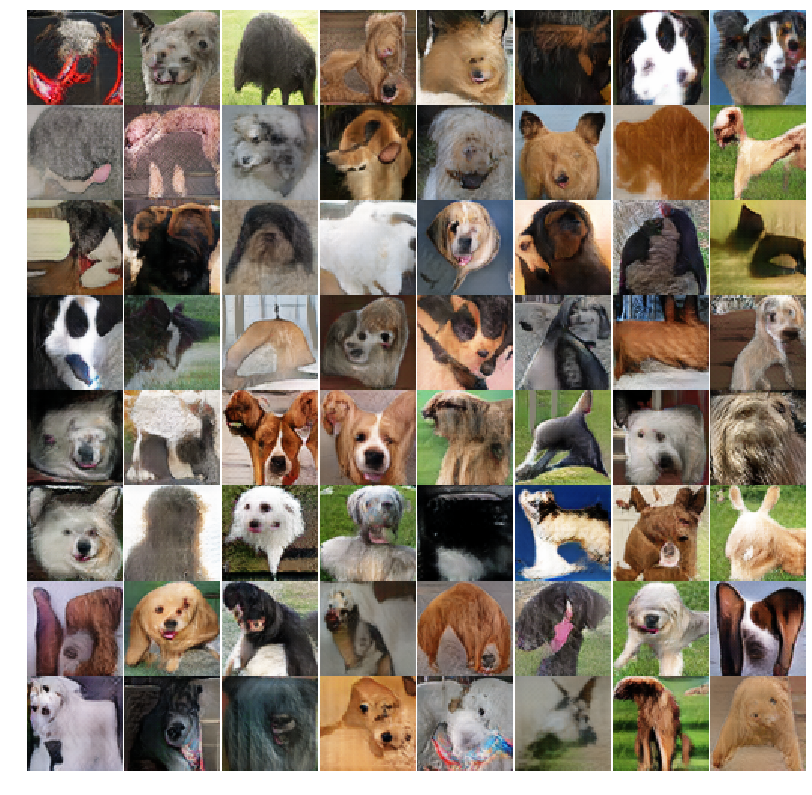

In [32]:
%%time
images_progress = train(dog_features_data, EPOCHS)

In [33]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [34]:
def generate_images(model, test_input, rows, cols):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(14,14))
    
    for i in range(predictions.shape[0]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow((predictions[i, :, :, :]  / 2) + 0.5)
        plt.axis('off')
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

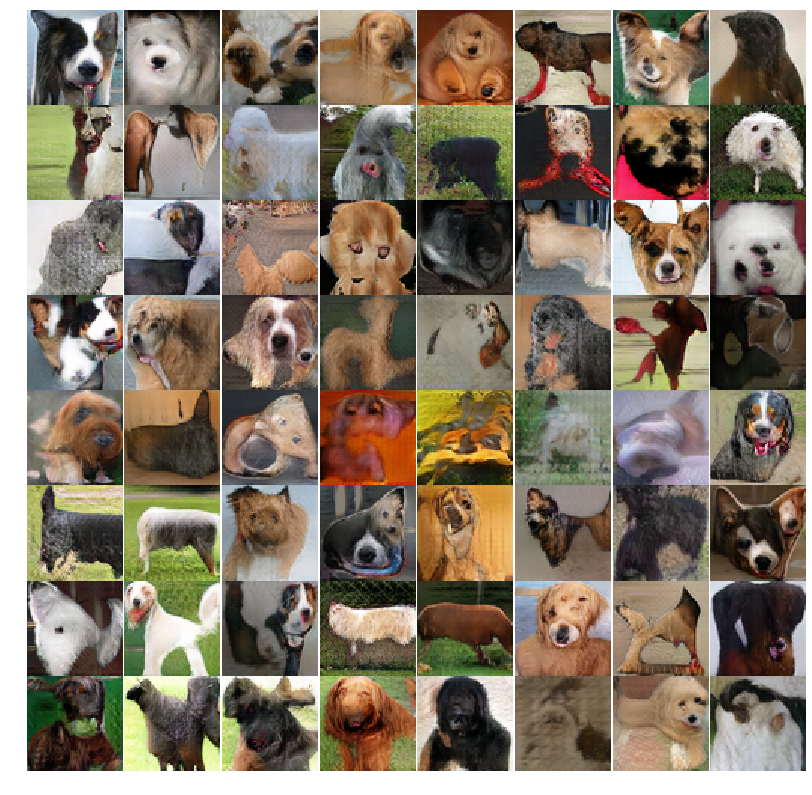

In [35]:
generate_images(generator, tf.random.normal([N_EXAMPLES, NOISE_DIM]), rows=8, cols=8)

In [36]:
# # Display a single image using the epoch number
# def display_image(epoch_no):
#     return PIL.Image.open('images/image_at_epoch_{:04d}.png'.format(epoch_no))

In [37]:
# display_image(EPOCHS)

In [38]:
# anim_file = 'dcgan.gif'

# with imageio.get_writer(anim_file, mode='I') as writer:
#     filenames = glob.glob('images/image*.png')
#     filenames = sorted(filenames)
#     last = -1
#     for i,filename in enumerate(filenames):
#         frame = 1*(i**2)
#         if round(frame) > round(last):
#             last = frame
#         else:
#             continue
#         image = imageio.imread(filename)
#         writer.append_data(image)

In [39]:
shutil.rmtree('images')
shutil.rmtree('training_checkpoints')